# Understanding the modal shifting and travel delays under short-term transport disruption – a case study of London tube strike

In [6]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from defined_methods import merge_csv, merge_csv_flow

# Data preparation

In [7]:
# read the administrative relationship encoding file
admin_rel = pd.read_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/oa_lsoa_msoa_la_trans.csv')
admin_rel

,oa21cd,lsoa21cd,msoa21cd,lad21cd,lad21nm
0,E00060255,E01011950,E02002490,E06000001,Hartlepool
1,E00060256,E01011949,E02002491,E06000001,Hartlepool
2,E00060257,E01011949,E02002491,E06000001,Hartlepool
3,E00060258,E01011951,E02002489,E06000001,Hartlepool
4,E00060259,E01011951,E02002489,E06000001,Hartlepool
...,...,...,...,...,...
178600,E00175269,E01033602,E02000968,E09000033,Westminster
178601,E00175270,E01033602,E02000968,E09000033,Westminster
178602,E00175271,E01033598,E02000968,E09000033,Westminster
178603,E00175272,E01033598,E02000968,E09000033,Westminster


(500648.6269499996, 564876.9020499996, 153596.6433500004, 203188.04565000077)

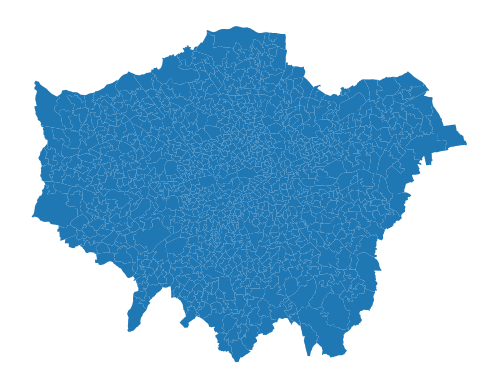

In [8]:
# read the spatial administrative boundary files
oa = gpd.read_file(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_oa.gpkg')
# lsoa = gpd.read_file(
#     '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_lsoa.gpkg')
msoa = gpd.read_file(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/lon_msoa.gpkg')
msoa.plot()
plt.axis('off')


In [9]:
msoa

,msoa21cd,msoa21nm,area,lad21cd,lad21nm,geometry
0,E02000001,City of London 001,3.150420,E09000001,City of London,"MULTIPOLYGON (((532153.703 182165.155, 532158...."
1,E02000002,Barking and Dagenham 001,2.161561,E09000002,Barking and Dagenham,"MULTIPOLYGON (((548881.304 190819.980, 548881...."
2,E02000003,Barking and Dagenham 002,2.141515,E09000002,Barking and Dagenham,"MULTIPOLYGON (((548958.555 189072.176, 548954...."
3,E02000004,Barking and Dagenham 003,2.492946,E09000002,Barking and Dagenham,"MULTIPOLYGON (((551550.056 187364.705, 551528...."
4,E02000005,Barking and Dagenham 004,1.187954,E09000002,Barking and Dagenham,"MULTIPOLYGON (((549237.051 187627.941, 549241...."
...,...,...,...,...,...,...
997,E02007111,Hackney 033,0.646501,E09000012,Hackney,"MULTIPOLYGON (((533467.193 183307.131, 533467...."
998,E02007112,Tower Hamlets 034,0.607494,E09000030,Tower Hamlets,"MULTIPOLYGON (((539048.000 181080.547, 539044...."
999,E02007113,Tower Hamlets 035,0.744019,E09000030,Tower Hamlets,"MULTIPOLYGON (((538560.000 181083.000, 538575...."
1000,E02007114,Tower Hamlets 036,0.549423,E09000030,Tower Hamlets,"MULTIPOLYGON (((538406.587 180300.310, 538431...."


## Individual

In [10]:
device = merge_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/device')
stay_time = merge_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/stay time')
travel_time = merge_csv(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UnitedNationsDevelopmentProgramme/Paper/Tube Strike Behaviour/travel_info_oa/travel time')
# drop the na values in the stay time dataset
stay_time = stay_time.dropna()
# convert the stay time from seconds to hours
stay_time['stay_time'] = stay_time['stay_time'].astype(int) / 3600


In [11]:
# Filtering for March 1, 2022, and March 3, 2022

device_313 = device[(device['date'] == '02/22/22') | (device['date'] == '03/01/22') | (device['date'] == '03/03/22')].copy().reset_index(drop=True)
device_313['date'] = pd.to_datetime(device_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

stay_time_313 = stay_time[(stay_time['date'] == '02/22/22') | (stay_time['date'] == '03/01/22') | (stay_time['date'] == '03/03/22')].copy().reset_index(
    drop=True)
stay_time_313['date'] = pd.to_datetime(stay_time_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

travel_time_313 = travel_time[
    (travel_time['date'] == '02/22/22') | (travel_time['date'] == '03/01/22') | (travel_time['date'] == '03/03/22')].copy().reset_index(drop=True)
travel_time_313['date'] = pd.to_datetime(travel_time_313['date'], format='%m/%d/%y').dt.strftime('%m/%d/%y')

In [29]:
# Device related behavioral test
test_device_lable = device_313['startid'].unique()[0]
# print(test_device_lable)
test_device = device_313[device_313['startid'] == test_device_lable]
# print(test_device)
test_device_stay = stay_time_313[stay_time_313['startid'] == test_device_lable]
# print(test_device_stay)
test_device_modes = travel_time_313[travel_time_313['startid'] == test_device_lable]
# print(test_device_travel)
# merge the test device status, stay time and travel time
test_device_status = pd.merge(test_device, test_device_stay, on=['startid', 'date', 'oa21cd', 'device_type'],
                              how='left')
test_device = test_device.drop_duplicates().reset_index(drop=True)
test_device_status

,startid,oa21cd,device_type,date,stay_time
0,1000015989590377328043415348373664771294182405...,E00018694,resident,03/01/22,8.210000
1,1000015989590377328043415348373664771294182405...,E00018691,passthrough,03/01/22,NaN
2,1000015989590377328043415348373664771294182405...,E00018688,passthrough,03/01/22,NaN
3,1000015989590377328043415348373664771294182405...,E00018694,resident,02/22/22,20.699167
4,1000015989590377328043415348373664771294182405...,E00018691,passthrough,02/22/22,NaN
5,1000015989590377328043415348373664771294182405...,E00018688,passthrough,02/22/22,NaN
6,1000015989590377328043415348373664771294182405...,E00185744,passthrough,02/22/22,NaN
7,1000015989590377328043415348373664771294182405...,E00018869,passthrough,02/22/22,NaN
8,1000015989590377328043415348373664771294182405...,E00018934,passthrough,02/22/22,NaN
9,1000015989590377328043415348373664771294182405...,E00018684,passthrough,02/22/22,NaN


In [30]:
test_device_modes

,stripid,startid,update_mode,time,distance,date
0,1.0,1000015989590377328043415348373664771294182405...,stationary,8.130556,0.019925,02/22/22
1,2.0,1000015989590377328043415348373664771294182405...,car,0.728611,4.099752,02/22/22
2,3.0,1000015989590377328043415348373664771294182405...,stationary,5.554167,0.097858,02/22/22
3,4.0,1000015989590377328043415348373664771294182405...,walks,0.256667,1.859487,02/22/22
4,5.0,1000015989590377328043415348373664771294182405...,stationary,0.493611,0.004711,02/22/22
5,6.0,1000015989590377328043415348373664771294182405...,walks,8.287222,4.080923,02/22/22
1331367,1.0,1000015989590377328043415348373664771294182405...,stationary,2.110000,0.433894,03/01/22
1331368,2.0,1000015989590377328043415348373664771294182405...,walks,0.365556,0.617287,03/01/22
1331369,3.0,1000015989590377328043415348373664771294182405...,stationary,6.100000,0.029396,03/01/22
1331370,4.0,1000015989590377328043415348373664771294182405...,walks,0.429167,0.921511,03/01/22


### Device behaviour calculation

In [14]:
device_313_status = pd.merge(device_313, stay_time_313, on=['startid', 'date', 'oa21cd', 'device_type'], how='left')
device_313_status = device_313_status.drop_duplicates().reset_index(drop=True)
# insert the MSOA and LSOA column from 'admin_rel'
device_313_status = pd.merge(device_313_status, admin_rel[['oa21cd', 'msoa21cd','lsoa21cd']], on=['oa21cd'], how='left')
device_313_status = device_313_status.drop_duplicates().reset_index(drop=True)

device_313_modes = travel_time_313.groupby(['startid', 'date', 'update_mode']).agg(
    {'time': 'sum', 'distance': 'sum'}).reset_index()

In [15]:
device_313_status

,startid,oa21cd,device_type,date,stay_time,msoa21cd,lsoa21cd
0,1000015989590377328043415348373664771294182405...,E00018694,resident,03/01/22,8.210000,E02006800,E01003714
1,1000037686428573366468895824408367961791352836...,E00008360,resident,03/01/22,18.706667,E02006786,E01032567
2,1000056811909521100485295490854336441641125953...,E00013578,resident,03/01/22,4.663889,E02000575,E01002726
3,1000064961804232476337777826703284484305799106...,E00007278,resident,03/01/22,23.500278,E02006793,E01001458
4,1000071212051388806025932869511590862120065353...,E00008696,resident,03/01/22,23.540278,E02000364,E01035640
...,...,...,...,...,...,...,...
7804985,9999986042492829152298314924974521522262434004...,E00000677,passthrough,02/22/22,NaN,E02000062,E01000141
7804986,9999986042492829152298314924974521522262434004...,E00000681,passthrough,02/22/22,NaN,E02000062,E01000141
7804987,9999986042492829152298314924974521522262434004...,E00000685,passthrough,02/22/22,NaN,E02000062,E01000141
7804988,9999991853406953377520742942162885721692630532...,E00014909,passthrough,02/22/22,NaN,E02000603,E01002960


In [16]:
device_313_modes

,startid,date,update_mode,time,distance
0,1000015989590377328043415348373664771294182405...,02/22/22,car,0.728611,4.099752
1,1000015989590377328043415348373664771294182405...,02/22/22,stationary,14.178333,0.122494
2,1000015989590377328043415348373664771294182405...,02/22/22,walks,8.543889,5.940410
3,1000015989590377328043415348373664771294182405...,03/01/22,stationary,8.210000,0.463290
4,1000015989590377328043415348373664771294182405...,03/01/22,walks,0.794722,1.538798
...,...,...,...,...,...
818147,9999986042492829152298314924974521522262434004...,02/22/22,stationary,20.183333,0.735870
818148,9999986042492829152298314924974521522262434004...,03/01/22,stationary,23.807222,0.303220
818149,9999986042492829152298314924974521522262434004...,03/03/22,stationary,23.602778,0.683795
818150,9999991853406953377520742942162885721692630532...,02/22/22,car,0.012222,0.317155


## System

In [0]:
traffic_flows = merge_csv_flow(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/[XH]Traffic flow')
road_network = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/[XH]road_network/road_network.shp'

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()

lsoa = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/London administrative boundaries/london_LSOA/london_LSOA.shp'

inoutter = '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/London administrative boundaries/lp-consultation-oct-2009-inner-outer-london-shp/lp-consultation-oct-2009-inner-outer-london.shp'
# tube_line = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_lines.json'
# tube_station = 'https://raw.githubusercontent.com/oobrien/vis/master/tubecreature/data/tfl_stations.json'

inoutter = gpd.read_file(inoutter)
inoutter.to_crs(epsg=27700, inplace=True)

lsoa = gpd.read_file(lsoa, crs={'init': 'epsg:27700'})
road_network = gpd.read_file(road_network, crs={'init': 'epsg:27700'})
road_network.rename(columns={'NAME': 'boroughs'}, inplace=True)
road_network.loc[:, ['cycle_lane', 'bus_lane']] = road_network[['cycle_lane', 'bus_lane']].fillna('n')

# clean the traffic flow data
traffic_flows = traffic_flows.drop_duplicates(['toid', 'date'])
traffic_flows = traffic_flows.groupby(['toid', 'date']).agg(
    {'bus': 'sum', 'car': 'sum', 'cycle': 'sum', 'walks': 'sum', 'stationary': 'sum'}).reset_index()
traffic_flows['total'] = traffic_flows['bus'] + traffic_flows['car'] + traffic_flows['cycle'] + traffic_flows[
    'walks'] + traffic_flows['stationary']

flows = pd.merge(
    road_network[
        ['toid', 'roadclassi', 'geometry', 'cycle_lane', 'bus_lane', 'boroughs', 'directiona', 'length', 'roadwidtha',
         'elevationg']],
    traffic_flows, left_on='toid', right_on='toid', how='left')
flows.set_geometry('geometry', inplace=True)

flows['classification'] = flows['roadclassi'].replace(
    {'Unknown': 'Local Road', 'Not Classified': 'Local Road', 'Unclassified': 'Local Road',
     'Classified Unnumbered': 'Local Road', 'A Road': 'Strategic Road', 'B Road': 'Strategic Road'})

flows.drop(columns=['roadclassi'], inplace=True)

stage_date = ['03/01/22', '02/22/22', '03/08/22']
flows = flows.loc[flows['date'].isin(stage_date)]

# label the regional level
flows = gpd.sjoin(flows, inoutter, how='inner', predicate='within')
flows = flows.drop(columns=['index_right', 'Source', 'Area_Ha', 'Shape_Leng', 'Shape_Area'])
flows.reset_index(drop=True, inplace=True)

regression = flows

# convert the dataframe
flows = pd.melt(flows,
                id_vars=['toid', 'classification', 'geometry', 'date', 'Boundary', 'cycle_lane', 'bus_lane',
                         'boroughs', 'directiona', 'length', 'roadwidtha', 'elevationg'],
                var_name='mode', value_name='flow')

flows = pd.pivot_table(flows,
                       index=['toid', 'classification', 'geometry', 'Boundary', 'mode', 'cycle_lane', 'bus_lane',
                              'boroughs', 'directiona', 'length', 'roadwidtha', 'elevationg'],
                       columns='date',
                       values='flow',
                       aggfunc='first').reset_index()

flows = flows.groupby(
    ['toid', 'mode', 'classification', 'geometry', 'Boundary', 'cycle_lane', 'bus_lane', 'boroughs', 'directiona',
     'length', 'roadwidtha', 'elevationg'],
    as_index=False).agg(
    {'03/01/22': 'first', '02/22/22': 'first', '03/08/22': 'first'})
# Calculate the impact and recovery flows for one strike
flows['impact_flow'] = flows['03/01/22'] - flows['02/22/22']
flows['recovery_flow'] = flows['03/08/22'] - flows['03/01/22']

# Calculate impact rate while avoiding division by zero
flows['impact_rate'] = flows.apply(
    lambda row: round(row['impact_flow'] / row['02/22/22'], 4) if row['02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
flows['recovery_rate'] = flows.apply(
    lambda row: round(row['recovery_flow'] / row['03/01/22'], 4) if row['03/01/22'] != 0 else 0, axis=1)

speed = merge_csv_flow(
    '/Users/zonghe/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Zonghe Ma/Zonghe Ma-STA-Investigating the relationship between modal shifting and road transport resilience under Tube strikes/Raw data/Traffic flow with speed')
speed = speed.groupby(['travel_mode', 'toid', 'date']).agg({'speed_overall': 'mean'}).reset_index()
speed = speed.pivot(index=['toid', 'travel_mode'], columns='date', values='speed_overall').reset_index()
speed.rename(columns={'03/01/22': 'speed_03/01/22', '02/22/22': 'speed_02/22/22', '03/08/22': 'speed_03/08/22'},
             inplace=True)

columns_to_sum = ['speed_03/01/22', 'speed_02/22/22', 'speed_03/08/22']
toid_mode_totals = speed.groupby(['toid', 'travel_mode'])[columns_to_sum].sum().reset_index()

# 创建一个包含 'total' 行的 DataFrame
total_row = toid_mode_totals.groupby('toid')[columns_to_sum].sum().reset_index()
total_row['travel_mode'] = 'total'

speed = pd.concat([toid_mode_totals, total_row], ignore_index=True)

# Calculate the impact and recovery flows for one strike
speed['impact_speed'] = speed['speed_03/01/22'] - speed['speed_02/22/22']
speed['recovery_speed'] = speed['speed_03/08/22'] - speed['speed_03/01/22']

speed['impact_speed_rate'] = speed.apply(
    lambda row: round(row['impact_speed'] / row['speed_02/22/22'], 4) if row['speed_02/22/22'] != 0 else 0, axis=1)
# Calculate recovery rate while avoiding division by zero
speed['recovery_speed_rate'] = speed.apply(
    lambda row: round(row['recovery_speed'] / row['speed_03/01/22'], 4) if row['speed_03/01/22'] != 0 else 0, axis=1)
flows = pd.merge(flows, speed, left_on=['toid', 'mode'], right_on=['toid', 'travel_mode'], how='left')
flows.drop(columns=['travel_mode'], inplace=True)

All = flows.copy()
All


# Indicators building

## Individual behaviours

### Trip distance & Trip time

#### per person

In [17]:
# Group by 'date' and 'update_mode', and aggregate 'time' and 'distance' by sum
tripdistance_ppl = device_313_modes.groupby(['date','startid']).agg(time_sum=('time', 'sum'), distance_sum=('distance', 'sum')).reset_index()
tripdistance_ppl[['time_sum', 'distance_sum']] = tripdistance_ppl[['time_sum', 'distance_sum']].round(2)


# Calculating mean values and renaming columns
tripdistance_ppl['time_mean'] = device_313_modes.groupby(['date','startid'])['time'].transform('mean').round(2)
tripdistance_ppl['distance_mean'] = device_313_modes.groupby(['date','startid'])['distance'].transform('mean').round(2)

tripdistance_ppl

,date,startid,time_sum,distance_sum,time_mean,distance_mean
0,02/22/22,1000015989590377328043415348373664771294182405...,23.45,10.16,7.82,3.39
1,02/22/22,1000037686428573366468895824408367961791352836...,9.10,74.56,7.82,3.39
2,02/22/22,1000056811909521100485295490854336441641125953...,23.64,18.54,7.82,3.39
3,02/22/22,1000064961804232476337777826703284484305799106...,7.00,0.07,4.50,1.00
4,02/22/22,1000071212051388806025932869511590862120065353...,23.10,0.03,4.50,1.00
...,...,...,...,...,...,...
321500,03/03/22,9999808333344375844762726236884984868022251899...,2.23,1.81,3.96,14.17
321501,03/03/22,9999826197003121838645007077519776294986488307...,22.04,26.10,3.96,14.17
321502,03/03/22,9999850430322788483675034814525089294618926457...,23.55,22.41,3.96,14.17
321503,03/03/22,9999901429782413329877307004404125705010246950...,23.64,10.30,4.76,7.64


#### per mode

In [18]:
# Group by 'date' and 'update_mode', and aggregate 'time' and 'distance' by sum
tripdistance_pm = device_313_modes.groupby(['date', 'update_mode']).agg(time_sum=('time', 'sum'), distance_sum=('distance', 'sum')).reset_index()
tripdistance_pm[['time_sum', 'distance_sum']] = tripdistance_pm[['time_sum', 'distance_sum']].round(2)


# Calculating mean values and renaming columns
tripdistance_pm['time_mean'] = device_313_modes.groupby(['date', 'update_mode'])['time'].transform('mean').round(2)
tripdistance_pm['distance_mean'] = device_313_modes.groupby(['date', 'update_mode'])['distance'].transform('mean').round(2)

tripdistance_pm

,date,update_mode,time_sum,distance_sum,time_mean,distance_mean
0,02/22/22,bus,9447.54,54316.07,2.17,23.85
1,02/22/22,car,173545.09,1911431.96,13.85,0.60
2,02/22/22,cycle,5886.55,45206.38,1.83,3.45
3,02/22/22,stationary,1360349.75,58732.54,13.94,0.62
4,02/22/22,train,4222.37,152378.01,1.81,3.21
5,02/22/22,tube,4736.07,96464.43,2.20,23.64
6,02/22/22,walks,117124.57,221504.45,13.94,0.62
7,03/01/22,bus,8568.91,47243.98,1.81,3.21
8,03/01/22,car,175020.65,1792015.59,2.20,23.64
9,03/01/22,cycle,7041.07,52971.33,13.69,0.62


#### 1111111 per OA

In [19]:
# merge dfs to aggrate in OA level
device_313_merged = pd.merge(device_313_status, device_313_modes, on=['date','startid'], how='left')

# Group by 'date' and 'oa21xd_x', and aggregate 'time' and 'distance' by sum
tripdistance_oa = device_313_merged.groupby(['date', 'oa21cd']).agg(time_sum=('time', 'sum'), distance_sum=('distance', 'sum')).reset_index()
tripdistance_oa[['time_sum', 'distance_sum']] = tripdistance_oa[['time_sum', 'distance_sum']].round(2)


# Calculating mean values and renaming columns
tripdistance_oa['time_mean'] = device_313_merged.groupby(['date', 'oa21cd'])['time'].transform('mean').round(2)
tripdistance_oa['distance_mean'] = device_313_merged.groupby(['date', 'oa21cd'])['distance'].transform('mean').round(2)

# calulations for device type
# Count the occurrences of each device type
device_type_counts = device_313_merged.groupby(['date', 'oa21cd', 'device_type']).size().reset_index(name='count')
# Calculate the total count for each 'date' and 'oa21cd' group
total_counts = device_type_counts.groupby(['date', 'oa21cd'])['count'].transform('sum')
# Calculate the rate (percentage) for each device type
device_type_counts['rate'] = (device_type_counts['count'] / total_counts) * 100

# Pivot the data
device_type_pivot = device_type_counts.pivot_table(index=['date', 'oa21cd'], columns='device_type', values='rate').reset_index()
# Reset the column names
device_type_pivot.columns.name = None
device_type_pivot.columns = ['date', 'oa21cd'] + [f'rate_{device_type}' for device_type in device_type_pivot.columns[2:]]
# Merge with tripdistance_oa
tripdistance_oa = pd.merge(tripdistance_oa, device_type_pivot, on=['date', 'oa21cd'], how='left').round(4)
tripdistance_oa['trip_rate'] = tripdistance_oa['rate_resident'] + tripdistance_oa['rate_passthrough']

tripdistance_oa = pd.merge(tripdistance_oa, oa, on=['oa21cd'], how='left')
tripdistance_oa = gpd.GeoDataFrame(tripdistance_oa, crs={'init': 'epsg:27700'}, geometry='geometry')

tripdistance_oa

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,date,oa21cd,time_sum,distance_sum,time_mean,distance_mean,rate_attraction,rate_passthrough,rate_resident,trip_rate,area,lsoa21cd,msoa21cd,lad21cd,lad21nm,geometry
0,02/22/22,E00000001,140.31,748.81,6.57,15.11,NaN,100.0000,NaN,NaN,0.006707,E01000001,E02000001,E09000001,City of London,"MULTIPOLYGON (((532303.125 181877.594, 532301...."
1,02/22/22,E00000003,104.29,771.78,6.57,15.11,NaN,100.0000,NaN,NaN,0.004187,E01000001,E02000001,E09000001,City of London,"MULTIPOLYGON (((532198.818 181863.087, 532192...."
2,02/22/22,E00000005,1069.75,4214.79,6.35,16.04,5.8091,94.1909,NaN,NaN,0.008736,E01000001,E02000001,E09000001,City of London,"MULTIPOLYGON (((532178.979 181764.041, 532180...."
3,02/22/22,E00000007,7205.17,30893.61,6.35,16.04,18.9024,80.6098,0.4878,81.0976,0.073494,E01000001,E02000001,E09000001,City of London,"MULTIPOLYGON (((532160.000 181671.000, 532174...."
4,02/22/22,E00000010,599.23,2295.42,6.35,16.04,NaN,100.0000,NaN,NaN,0.002533,E01000003,E02000001,E09000001,City of London,"MULTIPOLYGON (((532127.958 182133.192, 532106...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79021,03/03/22,E00190465,2213.85,7176.31,6.53,11.65,11.3684,87.3684,1.2632,88.6316,0.016853,E01033593,E02000974,E09000033,Westminster,"MULTIPOLYGON (((527030.984 181530.533, 527013...."
79022,03/03/22,E00190466,1544.86,5465.25,6.53,11.65,2.5000,93.4375,4.0625,97.5000,0.023714,E01002814,E02000591,E09000020,Kensington and Chelsea,"MULTIPOLYGON (((524878.910 178819.075, 524899...."
79023,03/03/22,E00190467,3911.61,14729.90,6.53,11.65,2.9639,94.2010,2.8351,97.0361,0.027888,E01002814,E02000591,E09000020,Kensington and Chelsea,"MULTIPOLYGON (((524766.157 178957.370, 524771...."
79024,03/03/22,E00190468,5888.96,21828.78,4.83,15.63,2.9777,96.6088,0.4136,97.0224,0.031571,E01002814,E02000591,E09000020,Kensington and Chelsea,"MULTIPOLYGON (((524881.786 179152.711, 524880...."


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/mapclassify/classifiers.py:511: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _fisher_jenks_means(values, classes=5, sort=True):


(500648.6269499996, 564876.9020499996, 153596.6433500004, 203188.04565000077)

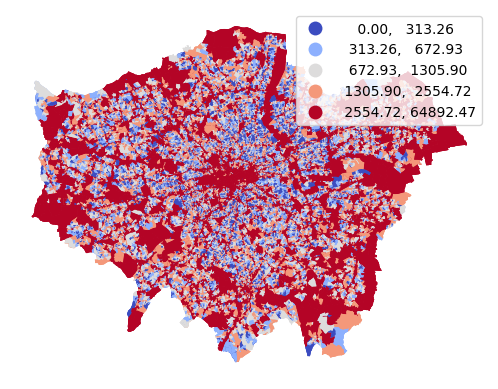

In [20]:
tripdistance_oa.plot(column='time_sum', cmap='coolwarm', legend=True, scheme= 'quantiles', k=5)
plt.axis('off')

### Trip rate

#### per person

In [21]:
# the rate of trip counts: selecte the non-residents status rates from the device status dataset

# Group by 'date' and then calculate the normalized value counts for each 'device_type'
device_type_rate_ppl = device_313_status.groupby(['date','startid'])['device_type'].value_counts(normalize=True).unstack(fill_value=0)

# Calculate the proportion of non-resident devices for each person by each date
triprate_ppl = 1 - device_type_rate_ppl.get('resident', 0)

triprate_ppl = pd.DataFrame(triprate_ppl).reset_index()
triprate_ppl.rename({'resident': 'trip_rate'}, axis=1, inplace=True)

triprate_ppl

,date,startid,trip_rate
0,02/22/22,1000015989590377328043415348373664771294182405...,0.928571
1,02/22/22,1000037686428573366468895824408367961791352836...,0.979167
2,02/22/22,1000056811909521100485295490854336441641125953...,0.944444
3,02/22/22,1000064961804232476337777826703284484305799106...,0.000000
4,02/22/22,1000071212051388806025932869511590862120065353...,0.000000
...,...,...,...
321497,03/03/22,9999808333344375844762726236884984868022251899...,0.666667
321498,03/03/22,9999826197003121838645007077519776294986488307...,0.952381
321499,03/03/22,9999850430322788483675034814525089294618926457...,0.975610
321500,03/03/22,9999901429782413329877307004404125705010246950...,0.800000


#### per mode

In [22]:
triprate_mode = device_313_merged.groupby(['date','startid'])['device_type'].value_counts(normalize=True).unstack(fill_value=0)

#### per OA

In [23]:
triprate_oa =tripdistance_oa[['date', 'oa21cd', 'trip_rate','geometry']].copy()
triprate_oa

,date,oa21cd,trip_rate,geometry
0,02/22/22,E00000001,NaN,"MULTIPOLYGON (((532303.125 181877.594, 532301...."
1,02/22/22,E00000003,NaN,"MULTIPOLYGON (((532198.818 181863.087, 532192...."
2,02/22/22,E00000005,NaN,"MULTIPOLYGON (((532178.979 181764.041, 532180...."
3,02/22/22,E00000007,81.0976,"MULTIPOLYGON (((532160.000 181671.000, 532174...."
4,02/22/22,E00000010,NaN,"MULTIPOLYGON (((532127.958 182133.192, 532106...."
...,...,...,...,...
79021,03/03/22,E00190465,88.6316,"MULTIPOLYGON (((527030.984 181530.533, 527013...."
79022,03/03/22,E00190466,97.5000,"MULTIPOLYGON (((524878.910 178819.075, 524899...."
79023,03/03/22,E00190467,97.0361,"MULTIPOLYGON (((524766.157 178957.370, 524771...."
79024,03/03/22,E00190468,97.0224,"MULTIPOLYGON (((524881.786 179152.711, 524880...."


(500648.6269499996, 564876.9020499996, 153596.6433500004, 203188.04565000077)

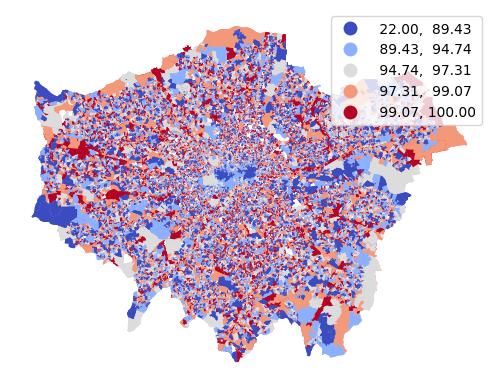

In [24]:
tripdistance_oa.plot(column='trip_rate', cmap='coolwarm', legend=True, scheme= 'quantiles', k=5)
plt.axis('off')

### Travel time & distance

In [25]:
# Group by 'date' and 'update_mode', and aggregate 'time' and 'distance' by sum
travel = device_313_modes.groupby(['date']).agg(time_sum=('time', 'sum'), distance_sum=('distance', 'sum')).reset_index()
travel[['time_sum', 'distance_sum']] = travel[['time_sum', 'distance_sum']].round(2)


# Calculating mean values and renaming columns
travel['time_mean'] = device_313_modes.groupby(['date','startid'])['time'].transform('mean').round(2)
travel['distance_mean'] = device_313_modes.groupby(['date','startid'])['distance'].transform('mean').round(2)

travel

,date,time_sum,distance_sum,time_mean,distance_mean
0,02/22/22,1675311.93,2540033.83,7.82,3.39
1,03/01/22,1656208.20,2311154.47,7.82,3.39
2,03/03/22,1645013.23,2378910.80,7.82,3.39


### Travel rate

In [26]:
# the rate of trip counts: selecte the non-residents status rates from the device status dataset

# Group by 'date' and then calculate the normalized value counts for each 'device_type'
device_type_rate_pd = device_313_status.groupby('date')['device_type'].value_counts(normalize=True).unstack(fill_value=0)

# Calculate the proportion of non-resident devices for each date
travelrate = 1 - device_type_rate_pd.get('resident', 0)

travelrate


date
02/22/22    0.969655
03/01/22    0.970378
03/03/22    0.968795
Name: resident, dtype: float64

## System performance

### Flow change

### Traffic congestion